In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import time
from configs import TIMEZONE, LOG_FILE_NAME, set_logger
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce
from alpaca.trading.requests import GetAssetsRequest
from alpaca.data.historical import StockHistoricalDataClient, CryptoHistoricalDataClient
from alpaca.data.requests import StockLatestQuoteRequest, StockBarsRequest, CryptoLatestQuoteRequest
from alpaca.data.requests import CryptoBarsRequest
from alpaca.trading.models import Order
from alpaca.data.timeframe import TimeFrame
from my_secrets import ALPACA_API_BASE_URL, PAPER_API_ID, PAPER_SECRET_KEY
import logging
import plotly.express as px
import plotly.graph_objects as go
set_logger()

In [36]:
import torch
import torch.nn as nn

In [37]:
from Trade_Class import Stock_Trader, Crypto_Trader
from Market_Monitor import Market_Monitor
from ALGO_crossover import bars_df_filter_dates, add_sma_columns, add_sma_crossovers

In [38]:
stock_trader = Stock_Trader(PAPER_API_ID, PAPER_SECRET_KEY, paper=True)
monitor = Market_Monitor(stock_trader.trading_client, TIMEZONE)

In [39]:
start = datetime(year=2015, month=1, day=1, hour=0, minute=0, second=0)
end = datetime(year=2023, month=2, day=1, hour=0, minute=0, second=0)
bars_df = stock_trader.get_bars('AAPL', start=start, end=end, time_resolution='day')
bars_df.reset_index(inplace=True)
bars_df.sort_values(by=['timestamp'], ascending=True, inplace=True)
print(bars_df.shape)
display(bars_df.head())

(1804, 9)


,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,AAPL,2015-12-01 05:00:00+00:00,118.75,118.81,116.86,117.34,34852374.0,187129.0,117.756760
1,AAPL,2015-12-02 05:00:00+00:00,117.05,118.11,116.08,116.28,33385643.0,180616.0,117.151198
2,AAPL,2015-12-03 05:00:00+00:00,116.55,116.79,114.22,115.20,41560785.0,245330.0,115.434888
3,AAPL,2015-12-04 05:00:00+00:00,115.29,119.25,115.11,119.03,57776977.0,307788.0,118.187290
4,AAPL,2015-12-07 05:00:00+00:00,118.98,119.86,117.81,118.28,32080754.0,190809.0,118.509111


In [40]:
def prep_RNN_data(bars_df, col='close', test_pct=0.25, scaler=None):
    array = bars_df[col].values
    if scaler!=None:
        array = scaler.fit_transform(array.reshape(-1, 1))
    train_size = len(array) - int(len(array)*test_pct)
    train_array = array[:train_size]
    test_array = array[train_size:]
    return train_array, test_array

In [41]:
SEQUENCE_LENGTH = 50
NUM_EXAMPLES = 949
NUM_LAYERS = 2
HIDDEN_SIZE = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
TEST_PCT = 0.25
BATCH_SIZE = 32
EPOCHS = 100

In [42]:
train_array, test_array = prep_RNN_data(bars_df, col='close', test_pct=TEST_PCT, scaler=MinMaxScaler())
len(train_array), len(test_array)

(1353, 451)

In [43]:
class RNNDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_len):
        """
        Takes in `data` which is a numpy array and `seq_len` which is an int.
        """
        self.data = data
        self.seq_len = seq_len
        self.data = torch.from_numpy(data).float()

    def __len__(self):
        return (len(self.data) - self.seq_len) - 1
    def __getitem__(self, index):
        return self.data[index : index+self.seq_len], self.data[index+self.seq_len]

In [44]:
train_dataset = RNNDataset(train_array, SEQUENCE_LENGTH)
test_dataset = RNNDataset(test_array, SEQUENCE_LENGTH)

len(train_dataset), len(test_dataset)

(1302, 400)

https://www.kaggle.com/code/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch

In [65]:
x, y = train_dataset[0]
x.shape, y.shape

(torch.Size([50, 1]), torch.Size([1]))

In [46]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [47]:
train_loader = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE, drop_last=True, shuffle=True)
train_loader = DeviceDataLoader(train_loader, DEVICE)
test_loader = torch.utils.data.DataLoader(test_dataset, BATCH_SIZE, drop_last=True)
test_loader = DeviceDataLoader(test_loader, DEVICE)

In [48]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        out, hn = self.rnn(x) #by not providing hidden state it is automatically set to 0's

        # out.size() --> batch_size, sequence_length, hidden_size --> torch.Size([32, 50, 100])
        # out[:, -1, :] --> batch_size, hidden_size -->torch.Size([32, 100]) --> just want last time step! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> batch_size, output_dim --> 100, 1
        return out

In [49]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        out, (hn, cn) = self.lstm(x) #by not providing hidden state and cell state they are automatically set to 0's

        # out.size() --> batch_size, sequence_length, hidden_size --> torch.Size([32, 50, 100])
        # out[:, -1, :] --> batch_size, hidden_size -->torch.Size([32, 100]) --> just want last time step! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> batch_size, output_dim --> 100, 1
        return out
    


In [50]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        out, hn = self.gru(x) #by not providing hidden state it is automatically set to 0's

        # out.size() --> batch_size, sequence_length, hidden_size --> torch.Size([32, 50, 100])
        # out[:, -1, :] --> batch_size, hidden_size -->torch.Size([32, 100]) --> just want last time step! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> batch_size, output_dim --> 100, 1
        return out

In [51]:
rnn_model = RNN(input_dim=1, hidden_dim=100, output_dim=1, num_layers=2)
rnn_model.to(DEVICE)
lstm_model = RNN(input_dim=1, hidden_dim=100, output_dim=1, num_layers=2)
lstm_model.to(DEVICE)
gru_model = GRU(input_dim=1, hidden_dim=100, output_dim=1, num_layers=2)
gru_model.to(DEVICE)

loss_fn = torch.nn.MSELoss()

rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.01)
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.01)

In [52]:
def fit_model(num_epochs: int, model: nn.Module, train_loader: torch.utils.data.DataLoader, test_loader: torch.utils.data.DataLoader, loss_fn, optimizer: torch.optim):
    training_losses = []
    testing_losses = []
    
    for e in range(num_epochs):
        # Forward pass
        train_losses = []
        model.train()
        for batch in train_loader:
            X_train, y_train = batch
            y_train_pred = model(X_train)
            loss = loss_fn(y_train_pred, y_train)
            train_losses.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        test_losses = []
        with torch.inference_mode():
            model.eval()
            for batch in test_loader:
                X_test, y_test = batch
                y_test_pred = model(X_test)
                loss = loss_fn(y_test_pred, y_test)
                test_losses.append(loss)

        training_losses.append(torch.mean(torch.FloatTensor(train_losses)))
        testing_losses.append(torch.mean(torch.FloatTensor(test_losses)))
        if e % 5 == 0:
            print(f"Epoch {e}  \tTrain MSE: {torch.mean(torch.FloatTensor(train_losses)):.5f}\tTest MSE: {torch.mean(torch.FloatTensor(test_losses)):.5f}")
    return training_losses, testing_losses

In [53]:
rnn_training_losses, rnn_testing_losses = fit_model(100, rnn_model, train_loader, test_loader, loss_fn, rnn_optimizer)

Epoch 0  	Train MSE: 0.29084	Test MSE: 0.08370
Epoch 5  	Train MSE: 0.06545	Test MSE: 0.18441
Epoch 10  	Train MSE: 0.03429	Test MSE: 0.00940
Epoch 15  	Train MSE: 0.03366	Test MSE: 0.02134
Epoch 20  	Train MSE: 0.03593	Test MSE: 0.00713
Epoch 25  	Train MSE: 0.03751	Test MSE: 0.00100
Epoch 30  	Train MSE: 0.03449	Test MSE: 0.00751
Epoch 35  	Train MSE: 0.03916	Test MSE: 0.00170
Epoch 40  	Train MSE: 0.03342	Test MSE: 0.02512
Epoch 45  	Train MSE: 0.03877	Test MSE: 0.02712
Epoch 50  	Train MSE: 0.03568	Test MSE: 0.00436
Epoch 55  	Train MSE: 0.04659	Test MSE: 0.00113
Epoch 60  	Train MSE: 0.03789	Test MSE: 0.01721
Epoch 65  	Train MSE: 0.06324	Test MSE: 0.00091
Epoch 70  	Train MSE: 0.03930	Test MSE: 0.03125
Epoch 75  	Train MSE: 0.03938	Test MSE: 0.00098
Epoch 80  	Train MSE: 0.03855	Test MSE: 0.04892
Epoch 85  	Train MSE: 0.04231	Test MSE: 0.00095
Epoch 90  	Train MSE: 0.03700	Test MSE: 0.01650
Epoch 95  	Train MSE: 0.03770	Test MSE: 0.00100


In [54]:
lstm_training_losses, lstm_testing_losses = fit_model(100, lstm_model, train_loader, test_loader, loss_fn, lstm_optimizer)

Epoch 0  	Train MSE: 0.52827	Test MSE: 0.02431
Epoch 5  	Train MSE: 0.03319	Test MSE: 0.00342
Epoch 10  	Train MSE: 0.03593	Test MSE: 0.00107
Epoch 15  	Train MSE: 0.03806	Test MSE: 0.00093
Epoch 20  	Train MSE: 0.00978	Test MSE: 0.00049
Epoch 25  	Train MSE: 0.00206	Test MSE: 0.00125
Epoch 30  	Train MSE: 0.00275	Test MSE: 0.00093
Epoch 35  	Train MSE: 0.00151	Test MSE: 0.00011
Epoch 40  	Train MSE: 0.00282	Test MSE: 0.00243
Epoch 45  	Train MSE: 0.00298	Test MSE: 0.00209
Epoch 50  	Train MSE: 0.00371	Test MSE: 0.00126
Epoch 55  	Train MSE: 0.00312	Test MSE: 0.00045
Epoch 60  	Train MSE: 0.00257	Test MSE: 0.00198
Epoch 65  	Train MSE: 0.00351	Test MSE: 0.00577
Epoch 70  	Train MSE: 0.00393	Test MSE: 0.00241
Epoch 75  	Train MSE: 0.00300	Test MSE: 0.00017
Epoch 80  	Train MSE: 0.00316	Test MSE: 0.00056
Epoch 85  	Train MSE: 0.00207	Test MSE: 0.00145
Epoch 90  	Train MSE: 0.00332	Test MSE: 0.00027
Epoch 95  	Train MSE: 0.00356	Test MSE: 0.00106


In [55]:
gru_training_losses, gru_testing_losses = fit_model(100, gru_model, train_loader, test_loader, loss_fn, gru_optimizer)

Epoch 0  	Train MSE: 0.02503	Test MSE: 0.00056
Epoch 5  	Train MSE: 0.00116	Test MSE: 0.00008
Epoch 10  	Train MSE: 0.00080	Test MSE: 0.00014
Epoch 15  	Train MSE: 0.00098	Test MSE: 0.00023
Epoch 20  	Train MSE: 0.00125	Test MSE: 0.00007
Epoch 25  	Train MSE: 0.00108	Test MSE: 0.00007
Epoch 30  	Train MSE: 0.00094	Test MSE: 0.00012
Epoch 35  	Train MSE: 0.00100	Test MSE: 0.00011
Epoch 40  	Train MSE: 0.00098	Test MSE: 0.00017
Epoch 45  	Train MSE: 0.00087	Test MSE: 0.00030
Epoch 50  	Train MSE: 0.00104	Test MSE: 0.00043
Epoch 55  	Train MSE: 0.00083	Test MSE: 0.00023
Epoch 60  	Train MSE: 0.00114	Test MSE: 0.00007
Epoch 65  	Train MSE: 0.00086	Test MSE: 0.00047
Epoch 70  	Train MSE: 0.00100	Test MSE: 0.00019
Epoch 75  	Train MSE: 0.00093	Test MSE: 0.00009
Epoch 80  	Train MSE: 0.00095	Test MSE: 0.00010
Epoch 85  	Train MSE: 0.00086	Test MSE: 0.00009
Epoch 90  	Train MSE: 0.00091	Test MSE: 0.00006
Epoch 95  	Train MSE: 0.00090	Test MSE: 0.00010


In [56]:
def plot_losses(num_epochs, training_losses, testing_losses, title_addition=''):
    training_losses = torch.FloatTensor(training_losses).cpu().numpy()
    testing_losses = torch.FloatTensor(testing_losses).cpu().numpy()

    fig, ax = plt.subplots()
    ax.plot(np.array(range(num_epochs)), training_losses, c='blue', label='Test Loss')
    ax.plot(np.array(range(num_epochs)), testing_losses, c='orange', label='Train Loss')

    ax.set_title(f"Training Vs Testing Losses\n{title_addition}")

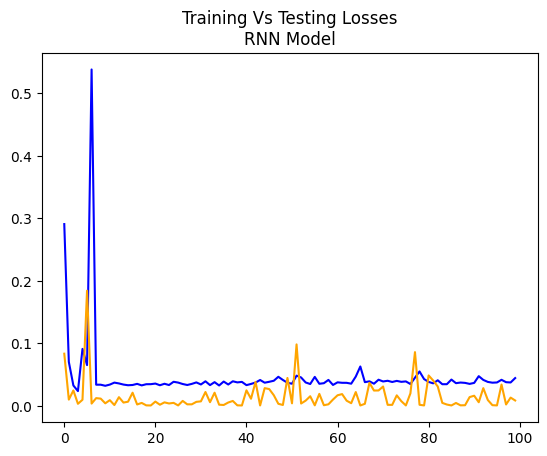

In [57]:
plot_losses(100, rnn_training_losses, rnn_testing_losses, title_addition='RNN Model')

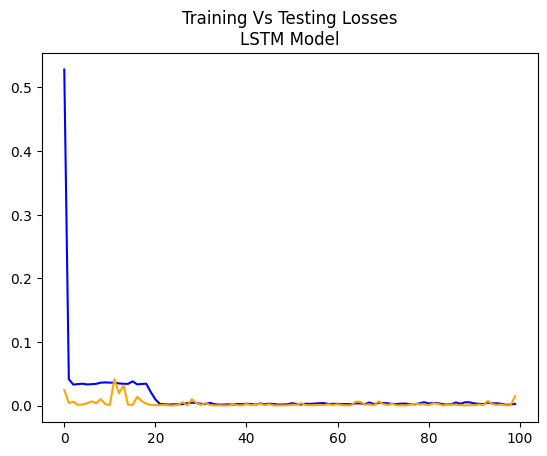

In [58]:
plot_losses(100, lstm_training_losses, lstm_testing_losses, title_addition='LSTM Model')

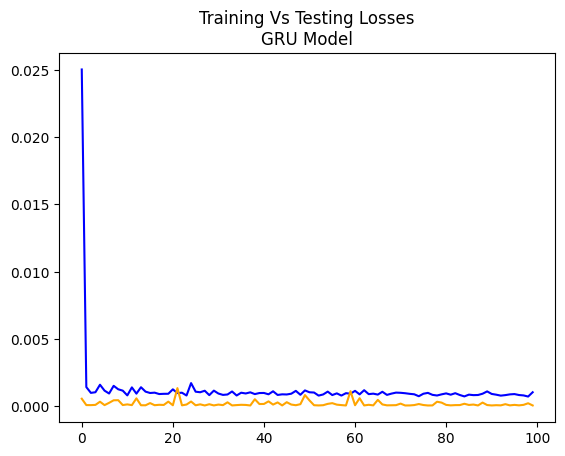

In [59]:
plot_losses(100, gru_training_losses, gru_testing_losses, title_addition='GRU Model')

In [ ]:
(100, rnn_model, train_loader, test_loader, loss_fn, rnn_optimizer)

In [84]:
def rnn_type_predict(model, array, device):
    model.eval()
    array = torch.from_numpy(array).float()
    array = torch.unsqueeze(array, 0) #unsqueeze once for batch size of 1
    array = array.to(device)
    with torch.inference_mode():
        pred = model(array)

    return float(pred.squeeze().cpu())

In [93]:
def visualize_predictions(model, train_array, test_array, device):
    x = np.arange((len(train_array)+len(test_array)))

    y = np.append(np.squeeze(train_array), np.squeeze(test_array))
    

    preds = []
    for i in range(50, len(test_array)-1):
        preds.append(rnn_type_predict(model, test_array[i-50:i], device))
    
    preds = np.array(preds)

    x_preds = np.arange(start=len(train_array)+50, stop=len(y)-1)

    #print(preds.shape, x_preds.shape)

    fig, ax = plt.subplots()

    ax.plot(x, y)
    ax.plot(x_preds, preds, c='orange', label='predictions')
    plt.show()
    return ax




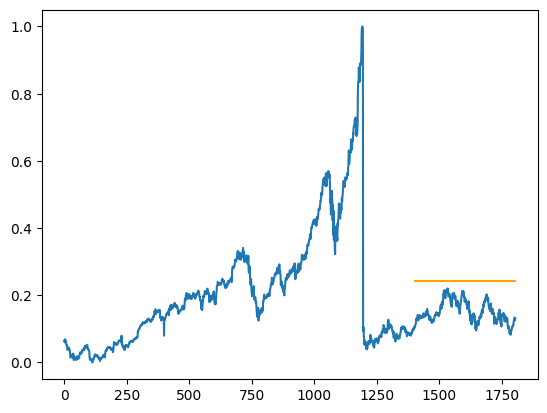

<Axes: >

In [96]:
visualize_predictions(rnn_model, train_array, test_array, DEVICE)

In [88]:


len(np.append(train_array, test_array))

1804

In [85]:
rnn_type_predict(rnn_model, train_array[:50], DEVICE)

0.24177201092243195

In [66]:
len(train_array), len(test_array)

(1353, 451)

In [60]:
len(test_dataset)

400

In [61]:
len(train_dataset)

1302

In [63]:
X, y = train_dataset[0]

In [64]:
X.shape, y.shape

(torch.Size([50, 1]), torch.Size([1]))